In [1]:
import os
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

from data_class import DataClass
from linear_noise_scheduler import LinearNoiseScheduler
from model import UNet

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 72
NUM_IMAGES = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_dir = r'./outputs'
checkpoint_dir = r'./checkpoints'

data_class = DataClass(BATCH_SIZE, IMG_SIZE, NUM_IMAGES)
dataloader = data_class.load_transformed_dataset()

In [3]:
image = next(iter(dataloader))[0][0]
image = image.to(device)    

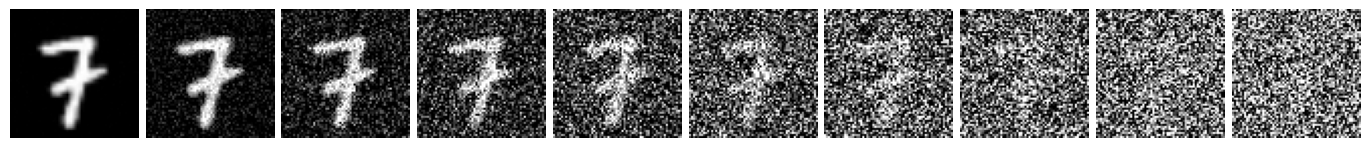

In [4]:
image = next(iter(dataloader))[0][0]
image = image.to(device)

plt.figure(figsize=(15, 15))
num_images = 10
T = 500 # timesteps
stepsize = int(T/num_images)
scheduler = LinearNoiseScheduler(timesteps=T, device=device)

for i in range(0, T, stepsize):
    t = torch.Tensor([i]).type(torch.int64)
    plt.subplot(1, num_images+1, int(i/stepsize) + 1)
    img, noise = scheduler.add_noise(image, t)
    data_class.show_tensor_image(img)

In [ ]:
# Parameters
in_ch = 1
out_ch = 1
time_dim = 256
lr = 3e-4
n_epochs = 2000

In [6]:
model = UNet(in_ch, out_ch, time_dim, device).to(device)
print(f"{sum(p.numel() for p in model.parameters()) / 10**6}M parameters")

23.331457M parameters


In [7]:
losses = []
mean_losses = []
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    # perceptual_loss = PerceptualLoss().to(device)
    # alpha = 0.01

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            t = scheduler.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = scheduler.add_noise(images, t)
            predicted_noise = model(x_t, t)

            # pred_x0 = scheduler.predict_start_from_noise(x_t, t, predicted_noise)
            loss = mse(predicted_noise, noise) 
            epoch_loss += loss.item() 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        mean_epoch_loss = epoch_loss / len(dataloader)
        losses.append(mean_epoch_loss)
        mean_loss = torch.tensor(losses[-10:]).mean().item() # calculate mean loss over last 10 epochs
        mean_losses.append(mean_loss)
        
        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt"))

        clear_output(wait=True)
        plt.plot(losses, label='Loss')
        plt.plot(mean_losses, label='Mean Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

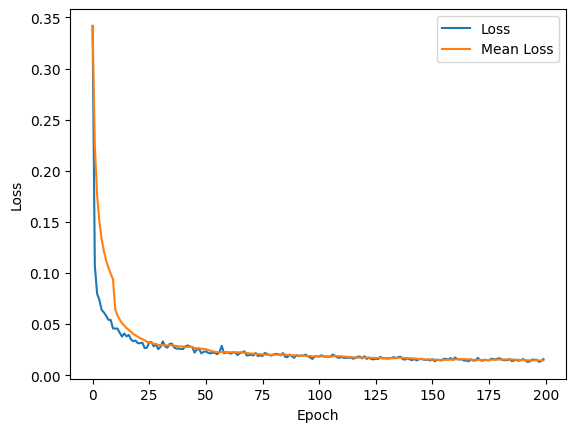

In [8]:
train()